### Generate Resonance Structures

In [1]:
def resonate(smiles,adj,smilesList,dictionary,inputForm,filter_structures,keep_isomorphic,showOctet):

    import rmgpy.molecule.resonance as resonance
    import rmgpy.molecule as molecule
    from IPython.display import display
    import rmgpy.chemkin as chemkin

    if inputForm[0] or inputForm[1]:
        if inputForm[0]: mol = molecule.Molecule(SMILES=smiles)
        elif inputForm[1]: mol = molecule.Molecule().fromAdjacencyList(adj)
        print "original molecule: {0}".format(mol.toSMILES())
#         print mol.toAdjacencyList()
        mol.update()
        display(mol)
        res = resonance.generate_resonance_structures(mol, keep_isomorphic=keep_isomorphic, filter_structures=filter_structures)
#         res = resonance.generate_resonance_structures(mol, keepIsomorphic=keep_isomorphic)
        num_structures = sum([1 for struc in res if struc.reactive])
        print "\nmolecule has {0} reactive resonance structures:".format(num_structures)
        for struc in res:
            display(struc)
            print struc, '\n', struc.toAdjacencyList()
            if showOctet:
                print "charge span: {0}".format(sum([abs(atom.charge) for atom in struc.vertices]) / 2)
                octetDeviation(struc)
            if not struc.reactive:
                print "reactive = {0}".format(struc.reactive)
            print '\n'
    elif inputForm[2]:
        for smiles in smilesList:
            mol = molecule.Molecule(SMILES=smiles)
            print "\n\n**********************\n"
            res = resonance.generate_resonance_structures(mol, filterStructures=filterStructures)
#             res = resonance.generate_resonance_structures(mol, keepIsomorphic=keep_isomorphic)
            print "molecule has {0} resonance structures:".format(len(res))
            for struc in res:
                display(struc)
                print struc, '\n', struc.toAdjacencyList()
                if showOctet:
                    print "charge span: {0}".format(sum([abs(atom.charge) for atom in struc.vertices]) / 2)
                    octetDeviation(struc)
                if not struc.reactive:
                    print "reactive = {0}".format(struc.reactive)
                print '\n'
    elif inputForm[3]:
        speciesDict = chemkin.loadSpeciesDictionary(dictionary)
        i=0
        for spc in speciesDict.iteritems():
            print "\n\n**********************\n"
            print "species {1} has {0} resonance structures:".format(len(spc[1].molecule),spc[0])
            for struc in spc[1].molecule:
                display(struc)
                print struc, '\n', struc.toAdjacencyList()
                if showOctet: octetDeviation(struc)
                if not struc.reactive:
                    print "reactive = {0}".format(struc.reactive)
                for atom in struc.vertices:
                    if atom.radicalElectrons:
                        print "atom.sortingLabel: {0}".format(atom.sortingLabel)
                print '\n'
            i+=1
        print i
            
                
def octetDeviation(struc):
    import rmgpy.molecule.filtration as filtration
#     struc.update()
    octetDeviation = 0
    for atom in struc.vertices:
        if atom.isNonHydrogen():
            print "atomType for {0} is {1}".format(atom,atom.atomType.label)
        electrons = 2 * (int(atom.getBondOrdersForAtom()) + atom.lonePairs) + atom.radicalElectrons
        if atom.isNonHydrogen():
            print "{0} val is {1}".format(atom,electrons)
        if atom.isCarbon():
            octetDeviation += abs(8 - electrons)  # octet on C
            if electrons > 8:
                octetDeviation += 1  # additional penalty for C with >8 electrons (as in [CH3-.][O+]=O)
                print "penalty for C > 8"
        elif atom.isNitrogen():
            if atom.lonePairs:
                octetDeviation += abs(8 - electrons)  # octet on N p1/2/3
            else:
                octetDeviation += min(abs(10 - electrons),abs(8 - electrons))  # octet/dectet for N p0
                # N p0 could also be close to octet and not necessarily dectet, as in O=[N+][O-]
            if electrons > 8:
                octetDeviation += 1  # additional penalty for N p0 with >8 electrons (as in O=[N.]=O,
                # [NH2.]=[:NH.], N#N=O, N#[N.]O, CCN=N#N)
                print "penalty for N > 8"
        elif atom.isOxygen():
            octetDeviation += abs(8 - electrons)  # octet on O
            if electrons > 8:
                octetDeviation += 1  # additional penalty for O with >8 electrons (as in O=[N+]=[O-.],
                # CC=[N+]=[::O-.])
                print "penalty for O > 8"
            if atom.atomType.label in ['O4sc','O4dc','O4tc']:
                octetDeviation += 1  # additional penalty for charged O with a double/triple bond
                # (as in [N-2][N+]#[O+], [O-]S#[O+], OS(S)([O-])#[O+], [OH+]=S(O)(=O)[O-];
                # [C-]#[O+] and [O-][O+]=O which are correct structures also get penalized here, but that's OK
                # since they are still selected as representative structures according to the rules here.)
                print "penalty for O4sc, O4dc, O4tc"
        elif atom.isSulfur():
            if atom.lonePairs == 0:
                octetDeviation += abs(12 - electrons)  # duodectet on S p0, eg O=S(=O)(O)O val 12, O[S](=O)=O val 11
            elif atom.lonePairs == 1:
                octetDeviation += min(abs(8 - electrons), abs(10 - electrons))  # octet/dectet on S p1,
                # eg [O-][S+]=O val 8, O[S]=O val 9, OS([O])=O val 10
                if electrons in [7,11]:
                    octetDeviation += 1  # eg O[S+][O-] val 7, N=[N+]=[S-]=O val 11 are undesired
                    print "penalty for S p1 in [7,11]"
            elif atom.lonePairs == 2:
                octetDeviation += min(abs(8 - electrons), abs(10 - electrons))  # octet/dectet on S p2,
                # eg [S][S] val 7, OS[O] val 8, [NH+]#[N+][S-][O-] val 9, O[S-](O)[N+]#N val 10
                if electrons == 11:
                    octetDeviation += 1  # eg [NH+]#[N+][S-2]=O val 11 is undesired
                    print "penalty for S p2 = 11"
            elif atom.lonePairs == 3:
                octetDeviation += abs(8 - electrons)  # octet on S p3, eg [S-][O+]=O
                if electrons == 10:
                    octetDeviation += 1  # eg [NH+]#[N+][S-2][O] val 10 is undesired
                    print "penalty for S p3 = 10"
            for atom2, bond in atom.bonds.iteritems():
                if atom2.isSulfur() and bond.isTriple():
                    print "penalty for S#S"
                    octetDeviation += 0.5  # penalty for S#S substructures. Often times sulfur can have a triple
                    # bond to another sulfur in a structure that obeys the octet rule, but probably shouldn't be a
                    # correct resonance structure. This adds to the combinatorial effect of resonance structures
                    # when generating reactions, yet probably isn't too important for reactivity.
                    # Examples: CS(=O)SC <=> CS(=O)#SC;
                    # [O.]OSS[O.] <=> [O.]OS#S[O.] <=> [O.]OS#[S.]=O; N#[N+]SS[O-] <=> N#[N+]C#S[O-]
        if atom.radicalElectrons == 2:
            octetDeviation += 2
    print "octet deviation: {0}".format(octetDeviation)


original molecule: [N+](=S=O)=[N-]


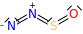


molecule has 4 reactive resonance structures:


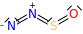

<Molecule "[N+](=S=O)=[N-]"> 
1 N u0 p0 c+1 {2,D} {3,D}
2 S u0 p1 c0 {1,D} {4,D}
3 N u0 p2 c-1 {1,D}
4 O u0 p2 c0 {2,D}

charge span: 1
atomType for N+ is N5ddc
N+ val is 8
atomType for S is S4dd
S val is 10
atomType for N- is N1dc
N- val is 8
atomType for O is O2d
O val is 8
octet deviation: 0




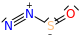

<Molecule "[N+](#N)[S-]=O"> 
1 N u0 p0 c+1 {2,S} {3,T}
2 S u0 p2 c-1 {1,S} {4,D}
3 N u0 p1 c0 {1,T}
4 O u0 p2 c0 {2,D}

charge span: 1
atomType for N+ is N5tc
N+ val is 8
atomType for S- is S2dc
S- val is 10
atomType for N is N3t
N val is 8
atomType for O is O2d
O val is 8
octet deviation: 0




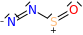

<Molecule "N(=[N-])[S+]=O"> 
1 N u0 p1 c0 {2,S} {3,D}
2 S u0 p1 c+1 {1,S} {4,D}
3 N u0 p2 c-1 {1,D}
4 O u0 p2 c0 {2,D}

charge span: 1
atomType for N is N3d
N val is 8
atomType for S+ is S4dc
S+ val is 8
atomType for N- is N1dc
N- val is 8
atomType for O is O2d
O val is 8
octet deviation: 0




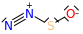

<Molecule "[N+](#N)S[O-]"> 
1 N u0 p0 c+1 {2,S} {3,T}
2 S u0 p2 c0 {1,S} {4,S}
3 N u0 p1 c0 {1,T}
4 O u0 p3 c-1 {2,S}

charge span: 1
atomType for N+ is N5tc
N+ val is 8
atomType for S is S2s
S val is 8
atomType for N is N3t
N val is 8
atomType for O- is O0sc
O- val is 8
octet deviation: 0


0.0545620918274


In [3]:
# debug:
#%pdb

import time

t = time.time()

smiles = '[S-](#[O+])=O'

adj = """
1 N u0 p2 c-1 {2,D}
2 N u0 p0 c+1 {1,D} {3,D}
3 S u0 p1 c0 {2,D} {4,D}
4 O u0 p2 c0 {3,D}
"""

smilesList = ['[O][O]','[S][S]','[S][O]','[O][S]','O=O','O=S','S=S','S=O']
dictionary = '/home/alongd/Code/RMG-database/input/kinetics/libraries/Sulfur/GlarborgH2S/dictionary.txt'

inputForm = [0,1,0,1]  # smiles? adj? smileList? dictionary?

filterStructures = 1
keepIsomorphic = 1
showOctet = 1
resonate(smiles,adj,smilesList,dictionary,inputForm,filterStructures,keepIsomorphic,showOctet)

print(time.time()-t)
